In [81]:
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate

import kagglehub

from constants import dataset_name, opciones, CV, scoring
from utils import cargar_imagenes, evaluar_rendimiento, save_excel_cv

from modelos.RegresionLogistica import regresion_logistica
from modelos.CNN import cnn1, cnn2
from modelos.KNN import knn, knn_with_gridsearch
from modelos.ArbolDeDecision import arbol_decision, arbol_decision_vgg16, arbol_vgg16_pca
from modelos.MobileNetV2 import train_mobilenetv2_model
from modelos.RandomForest import random_forest, rforest_vgg16_pca, rforest_vgg16_pca_hog
from Extractores_con_clasificador.hog_main import main_hog, extract_hog_features
from Extractores_con_clasificador.ann_hog import ann_hog
from Extractores_con_clasificador.svm_hog import svm_hog
from tensorflow.keras.utils import to_categorical
from modelos.MobileNetV2 import train_mobilenetv2_model

import matplotlib.pyplot as plt

# Descargar dataset
path = kagglehub.dataset_download(dataset_name)

# cargar train y test
X_train_rgb_64, y_train = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), target_size=(64, 64))
X_test_rgb_64, y_test = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), target_size=(64, 64))

# Codificar etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

epochs = 100
batch_size = 100
history = []


In [82]:
def validacion(X_test, y_test_encoded, y_pred):
    # Visualizar las imágenes y las predicciones
    plt.figure(figsize=(12, 6))  # Ajustar tamaño

    for i in range(10):  # Mostrar 10 imágenes
        index = random.randint(0, X_test.shape[0] - 1)
        image_to_show = X_test[index]
        true_label_num = y_test_encoded[index]  # Etiqueta real codificada
        
        # Obtener la predicción
        pred_label_num = np.argmax(y_pred[index])  # Etiqueta predicha
        
        true_label_str = class_names[true_label_num]  # Nombre de la clase real
        pred_label_str = class_names[pred_label_num]  # Nombre de la clase predicha

        # Dibujar imagen
        plt.subplot(2, 5, i + 1)
        plt.imshow(image_to_show)
        plt.axis('off')

        # Mostrar la predicción
        if true_label_num == pred_label_num:
            plt.title(pred_label_str)
        else:
            plt.title(f"{pred_label_str} != {true_label_str}", color='red')

In [83]:
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

from constants import CV, scoring

def knn(X_train_rgb, y_train_encoded, X_test_rgb):
    X_train_flattened = X_train_rgb.reshape(X_train_rgb.shape[0], -1)
    X_test_flattened = X_test_rgb.reshape(X_test_rgb.shape[0], -1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flattened)
    
    pca = PCA(n_components=50)  # You can adjust n_components as needed
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    knn_model = KNeighborsClassifier(n_neighbors=3)

    scoresKNN = cross_validate(knn_model, X_train_pca, y_train_encoded, cv=CV, scoring=scoring)
    
    knn_model.fit(X_train_pca, y_train_encoded)

    # Return both the trained KNN model and PCA model as a tuple
    return knn_model, pca, scoresKNN


def knn_with_gridsearch(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded):
    # Aplanar las imágenes
    X_train_flattened = X_train_rgb.reshape(X_train_rgb.shape[0], -1)
    X_test_flattened = X_test_rgb.reshape(X_test_rgb.shape[0], -1)

    # Escalar las características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flattened)
    X_test_scaled = scaler.transform(X_test_flattened)

    # Definir el espacio de búsqueda de hiperparámetros
    param_grid = {
        'pca__n_components': [30, 50],
        'knn__n_neighbors': [3, 7]
    }

    # Crear un pipeline
    pipeline = Pipeline([
        ('pca', PCA()),
        ('knn', KNeighborsClassifier())
    ])

    # Aplicar GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=CV, scoring=scoring, refit='accuracy')
    grid_search.fit(X_train_scaled, y_train_encoded)

    print(f"Mejores parámetros: {grid_search.best_params_}")

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_
    best_pca = best_model.named_steps['pca']
    best_knn = best_model.named_steps['knn']

    results = pd.DataFrame(grid_search.cv_results_)[[
        'param_pca__n_components', 'param_knn__n_neighbors',
        'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall',
        'mean_test_f1', 'mean_test_roc_auc'
    ]]

    print(results.sort_values(by='mean_test_accuracy', ascending=False))
    #visualize_knn_predictions(best_knn, best_pca, scaler, X_test_rgb_64, y_test_encoded, class_names)
    y_pred_knn = grid_search.predict(X_test_scaled)
    validacion(X_test_rgb, y_test_encoded, y_pred_knn)

    return best_knn, best_pca, results 

Mejores parámetros: {'knn__n_neighbors': 7, 'pca__n_components': 30}
   param_pca__n_components  param_knn__n_neighbors  mean_test_accuracy  \
2                       30                       7            0.435028   
3                       50                       7            0.429096   
1                       50                       3            0.414689   
0                       30                       3            0.410169   

   mean_test_precision  mean_test_recall  mean_test_f1  mean_test_roc_auc  
2             0.435433          0.420852      0.416206           0.728536  
3             0.439164          0.411422      0.405764           0.724112  
1             0.427729          0.402452      0.400008           0.686374  
0             0.422689          0.400314      0.399276           0.687580  


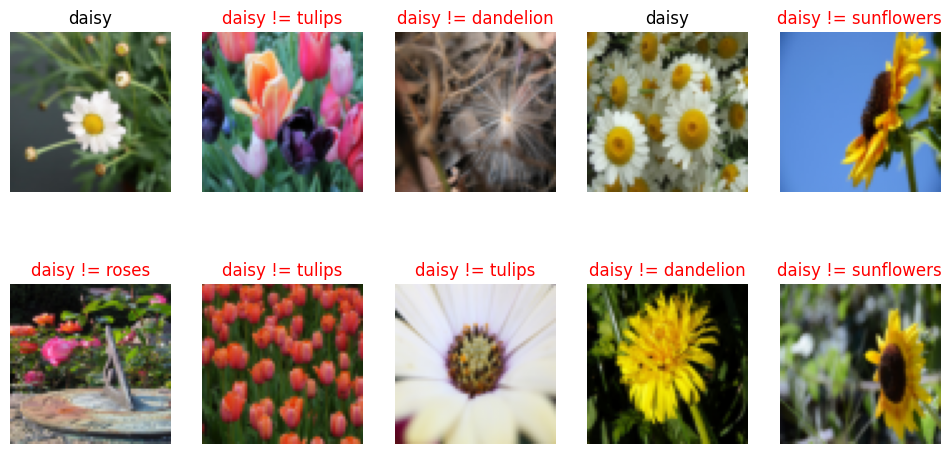

In [88]:
best_knn, best_pca, results_KNN = knn_with_gridsearch(X_train_rgb_64, y_train_encoded, X_test_rgb_64, y_test_encoded)


In [103]:
print(best_knn)
print(best_pca)
print(results_KNN)

KNeighborsClassifier(n_neighbors=7)
PCA(n_components=30)
   param_pca__n_components  param_knn__n_neighbors  mean_test_accuracy  \
0                       30                       3            0.410169   
1                       50                       3            0.414689   
2                       30                       7            0.435028   
3                       50                       7            0.429096   

   mean_test_precision  mean_test_recall  mean_test_f1  mean_test_roc_auc  
0             0.422689          0.400314      0.399276           0.687580  
1             0.427729          0.402452      0.400008           0.686374  
2             0.435433          0.420852      0.416206           0.728536  
3             0.439164          0.411422      0.405764           0.724112  


In [85]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

from constants import scoring, CV
import matplotlib.pyplot as plt
import random
import numpy as np
def rforest_vgg16_pca_hog(X_train, y_train, X_test, X_train_gray, X_test_gray, input_shape=(64,64,3), n_components=500):
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    # Extraer características con VGG16
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    # Aplanar las características extraídas
    X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
    X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)
    
    pca = PCA(n_components=500, svd_solver='randomized')  # Elegimos 200 características más relevantes
    X_train_pca = pca.fit_transform(X_train_features_flat)
    X_test_pca = pca.transform(X_test_features_flat)

    # Extraer características HOG
    X_train_hog = extract_hog_features(X_train_gray)
    X_test_hog = extract_hog_features(X_test_gray)
    # Normalizar características
    scaler = StandardScaler()
    X_train_hog_scaled = scaler.fit_transform(X_train_hog)
    X_test_hog_scaled = scaler.transform(X_test_hog)

    # Concatenar VGG16 + HOG
    X_train_combined = np.hstack((X_train_pca, X_train_hog_scaled))
    X_test_combined = np.hstack((X_test_pca, X_test_hog_scaled))

    # Entrenar Random Forest con características combinadas
    model_rf_combined = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
    
    cv_scores = cross_validate(model_rf_combined, X_train_combined, y_train, cv=CV, scoring=scoring)
    #print(f'Accuracy scores for each fold: {cv_scores}')
    #print(f'Mean cross-validation accuracy: {cv_scores.mean()}')
    #print(f'Mean cross-validation accuracy: {cv_scores["test_score"].mean()}')

    model_rf_combined.fit(X_train_combined, y_train)
    y_pred_rf = model_rf_combined.predict(X_test_combined)

    validacion(X_test, y_test_encoded, y_pred_rf)

    return model_rf_combined, cv_scores

In [86]:
X_train_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), channel_mode="grayscale")
X_test_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), channel_mode="grayscale")

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 464ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


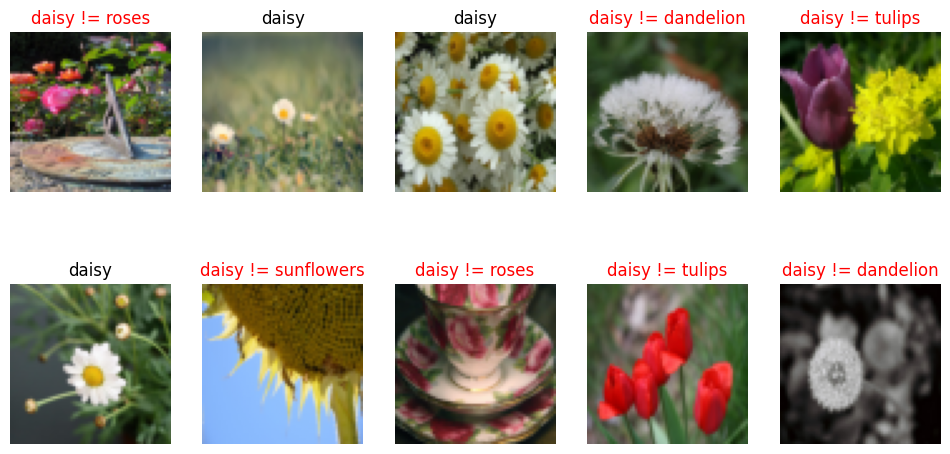

In [89]:
model_rf_vgg_pca_hog, scores_rf_vgg_pca_hog = rforest_vgg16_pca_hog(X_train_rgb_64, y_train_encoded, X_test_rgb_64, X_train_gray, X_test_gray)

In [104]:
print(scores_rf_vgg_pca_hog)

{'fit_time': array([57.03687286, 57.75530291, 58.63800883, 57.5058589 , 57.21213508]), 'score_time': array([0.18205428, 0.19486666, 0.21000838, 0.17675304, 0.18600368]), 'test_accuracy': array([0.47175141, 0.50847458, 0.48728814, 0.5       , 0.50282486]), 'test_precision': array([0.48036714, 0.51298292, 0.49314922, 0.5192612 , 0.51314899]), 'test_recall': array([0.45286691, 0.49203195, 0.46949149, 0.48030549, 0.48352989]), 'test_f1': array([0.45306809, 0.49380836, 0.47097024, 0.4810936 , 0.48378187]), 'test_roc_auc': array([0.7575709 , 0.77457836, 0.77561203, 0.77389724, 0.7855328 ])}


In [91]:
def rforest_vgg16_pca(X_train, y_train, X_test, input_shape=(256, 256, 3), n_components=500):
    
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    # Extraer características con VGG16
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    # Aplanar las características extraídas
    X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
    X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)
    
    pca = PCA(n_components=500, svd_solver='randomized')  # Elegimos 200 características más relevantes
    X_train_pca = pca.fit_transform(X_train_features_flat)
    X_test_pca = pca.transform(X_test_features_flat)

    modelRF = RandomForestClassifier(
        n_estimators=200,  # Más árboles = mejor generalización
        max_depth=30,  # Mayor profundidad
        min_samples_split=3,  # Menos datos necesarios para dividir
        min_samples_leaf=2,  # Evita ramas muy pequeñas
        random_state=42
    )

    # Validación cruzada
    scoresRF = cross_validate(modelRF, X_train_pca, y_train, cv=CV, scoring=scoring)

    modelRF.fit(X_train_pca, y_train)
    y_pred_rf = modelRF.predict(X_test_pca)
    
    validacion(X_test_rgb_64, y_test_encoded, y_pred_rf)
    
    # Precisión con VGG16 + PCA
    return modelRF, scoresRF

In [90]:
model_rf_vgg_pca, scores_vgg_pca = rforest_vgg16_pca(X_train_rgb_64, y_train_encoded, X_test_rgb_64, input_shape=(64, 64, 3), n_components=500)

111/111 ━━━━━━━━━━━━━━━━━━━━ 46s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


In [92]:
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

def random_forest(X_train, y_train, X_test, y_test_encoded, class_names):
    # Aplanar imágenes
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Crear y entrenar el modelo Random Forest
    modelRF = RandomForestClassifier(n_estimators=100, random_state=42)
    modelRF.fit(X_train_flat, y_train)

    # Hacer predicciones
    y_pred_rf = modelRF.predict(X_test_flat)

    # Validación cruzada
    scoresRF = cross_validate(modelRF, X_train_flat, y_train, cv=5, scoring='accuracy')

    # Visualizar imágenes y predicciones

    validacion(X_test_rgb_64, y_test_encoded, y_pred_rf)

    return modelRF, scoresRF  # También devuelve las predicciones

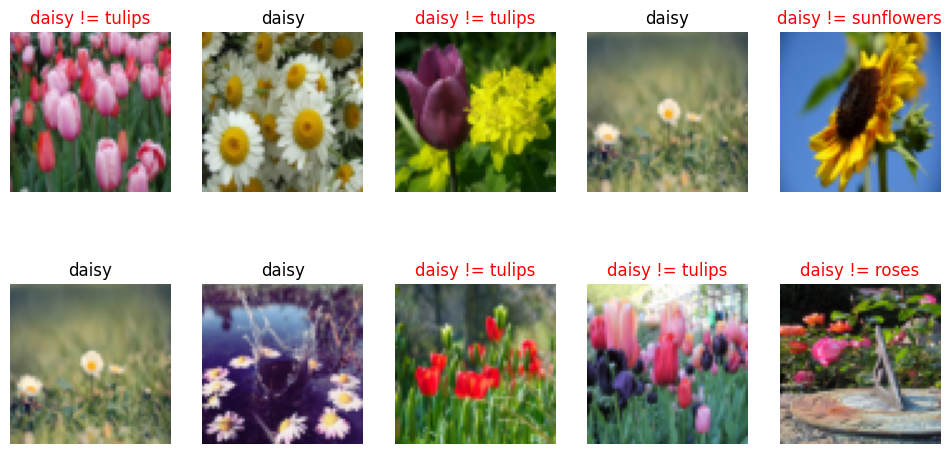

In [93]:
modelRF, scoresRF = random_forest(X_train_rgb_64, y_train_encoded, X_test_rgb_64, y_test_encoded, class_names)

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

def cnn1():
    model = models.Sequential()
    model.add(keras.Input(shape=(64, 64, 3)))  # Nueva dimensión de entrada

    # Primera capa convolucional
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Segunda capa convolucional
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Global Average Pooling para reducir dimensionalidad
    model.add(layers.GlobalAveragePooling2D())

    # Capa densa
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout para evitar el sobreajuste

    # Capa de salida con 5 clases
    model.add(layers.Dense(5, activation='softmax'))

    # Compilación del modelo
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

model1 = cnn1()
epochs = 100
batch_size = 100
history = []
history.append( model1.fit(X_train_rgb_64, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(X_test_rgb_64, y_test_encoded)) )
y_pred_cnn = model1.predict(X_test_rgb_64)


validacion(X_test_rgb_64, y_test_encoded, y_pred_cnn)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.2295 - loss: 1.5930 - val_accuracy: 0.3200 - val_loss: 1.5299
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.3309 - loss: 1.4908 - val_accuracy: 0.3800 - val_loss: 1.4072
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4032 - loss: 1.3623 - val_accuracy: 0.4000 - val_loss: 1.3133
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.4370 - loss: 1.3029 - val_accuracy: 0.4000 - val_loss: 1.2629
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.4576 - loss: 1.2571 - val_accuracy: 0.4800 - val_loss: 1.2369
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.4828 - loss: 1.2191 - val_accuracy: 0.4600 - val_loss: 1.2008
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.5020 - loss: 1.1920 - val_accuracy: 0.5000 - val_loss: 1.2035
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.5072 - loss: 1.1810 - val_accu

In [105]:
print(history)

[]


In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

from constants import CV, scoring

def regresion_logistica(X_train, y_train_encoded, X_test, y_test_encoded):
    # Aplanar las imágenes de 4D a 2D
    X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Aplanar a 2D: [n_samples, n_features]
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    # Entrenar modelo de Regresión Logística
    modelLR = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000)

    # Validación cruzada
    scoresLR = cross_validate(modelLR, X_train_flat, y_train_encoded, cv=CV, scoring=scoring)

    # Entren
    modelLR.fit(X_train_flat, y_train_encoded)
    # Realizar las predicciones sobre el conjunto de prueba
    y_pred_lr = modelLR.predict(X_test_flat)

    validacion(X_test, y_test_encoded, y_pred_lr)

    return modelLR, scoresLR

In [96]:
model_lr, scores_lr = regresion_logistica(X_train_rgb_64, y_train_encoded, X_test_rgb_64, y_test_encoded)


KeyboardInterrupt: 

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

def arbol_decision_vgg16(X_train, y_train, X_test, y_test, input_shape=(256,256,3)):
    # Cargar VGG16 preentrenado SIN la capa superior
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    # Extraer características con VGG16
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    # Aplanar las características extraídas
    X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
    X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

    # Validación cruzada con las características extraídas
    model_tree_vgg = DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=42)

    scores_tree_vgg = cross_validate(model_tree_vgg, X_train_features_flat, y_train, cv=5, scoring=scoring)
    #print(f"Precisión media de validación cruzada con VGG16: {np.mean(scores_tree_vgg):.4f}")
    # Mostrar los resultados promedio de cada métrica
    print("Resultados de Validación Cruzada:")
    for metric in scoring:
        mean_score = np.mean(scores_tree_vgg[f'test_{metric}'])
        print(f"{metric}: {mean_score:.4f}")
    # Entrenar el modelo con todo el conjunto de entrenamiento
    model_tree_vgg.fit(X_train_features_flat, y_train)
    y_pred_tree_vgg = model_tree_vgg.predict(X_test_features_flat)
    validacion(X_test, y_test_encoded, y_pred_tree_vgg)
    return model_tree_vgg, scores_tree_vgg

111/111 ━━━━━━━━━━━━━━━━━━━━ 54s 482ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Resultados de Validación Cruzada:
accuracy: 0.4607
precision: 0.4581
recall: 0.4512
f1: 0.4511
roc_auc: 0.6862


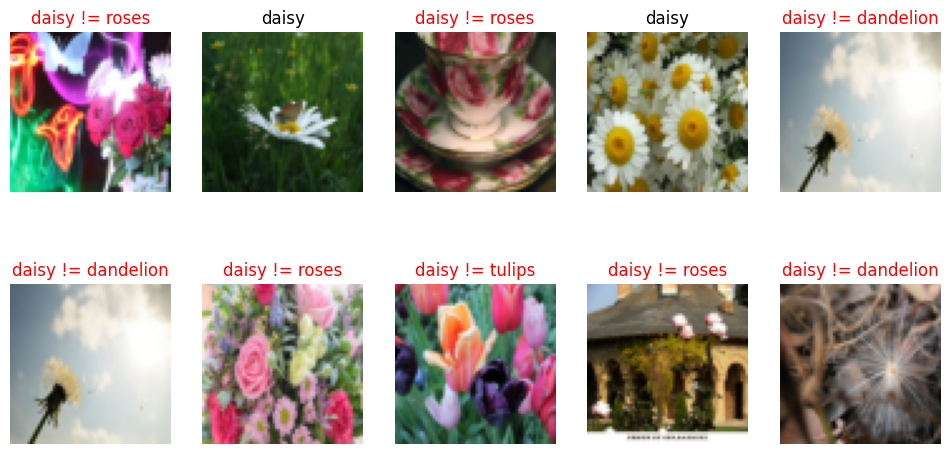

In [100]:
model_tree_vgg, scores_tree_vgg = arbol_decision_vgg16(X_train_rgb_64, y_train_encoded, X_test_rgb_64, y_test_encoded, input_shape=(64,64,3))


In [108]:
print(scores_tree_vgg)

{'fit_time': array([2.92314553, 2.79935145, 2.73940516, 2.72962141, 3.13327861]), 'score_time': array([0.01353049, 0.01208973, 0.0129962 , 0.01604486, 0.01669478]), 'test_accuracy': array([0.45762712, 0.46327684, 0.45621469, 0.45480226, 0.47175141]), 'test_precision': array([0.45753203, 0.46106483, 0.45660949, 0.45518212, 0.46020465]), 'test_recall': array([0.4484089 , 0.45764843, 0.4502945 , 0.44352499, 0.45596342]), 'test_f1': array([0.44756566, 0.45650768, 0.45091984, 0.44456435, 0.45597603]), 'test_roc_auc': array([0.68809414, 0.69802387, 0.6701636 , 0.68289768, 0.69160653])}


In [101]:
def arbol_vgg16_pca(X_train, y_train, X_test, y_test_encoded, input_shape=(256,256,3), n_components=500):
    # Cargar VGG16 preentrenado SIN la capa superior
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    # Extraer características con VGG16
    X_train_features = feature_extractor.predict(X_train)
    X_test_features = feature_extractor.predict(X_test)

    # Aplanar las características extraídas
    X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
    X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

    # Reducción de dimensionalidad con PCA
    pca = PCA(n_components=n_components, svd_solver='randomized')
    X_train_pca = pca.fit_transform(X_train_features_flat)
    X_test_pca = pca.transform(X_test_features_flat)

    # Validación cruzada con PCA y VGG16
    model_tree_pca = DecisionTreeClassifier(criterion="gini", max_depth=20, random_state=42)
    
    scores_tree_pca = cross_validate(model_tree_pca, X_train_pca, y_train, cv=5, scoring=scoring)
    #print(f"Precisión media de validación cruzada con VGG16 y PCA: {np.mean(scores_tree_pca):.4f}")
    print("Resultados de Validación Cruzada:")
    for metric in scoring:
        mean_score = np.mean(scores_tree_pca[f'test_{metric}'])
        print(f"{metric}: {mean_score:.4f}")
    # Entrenar el modelo con todo el conjunto de entrenamiento
    model_tree_pca.fit(X_train_pca, y_train)
    y_pred_tree_pca = model_tree_pca.predict(X_test_pca)
    validacion(X_test, y_test_encoded, y_pred_tree_pca)
    return model_tree_pca, scores_tree_pca

111/111 ━━━━━━━━━━━━━━━━━━━━ 50s 447ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
Resultados de Validación Cruzada:
accuracy: 0.4189
precision: 0.4121
recall: 0.4126
f1: 0.4114
roc_auc: 0.6334


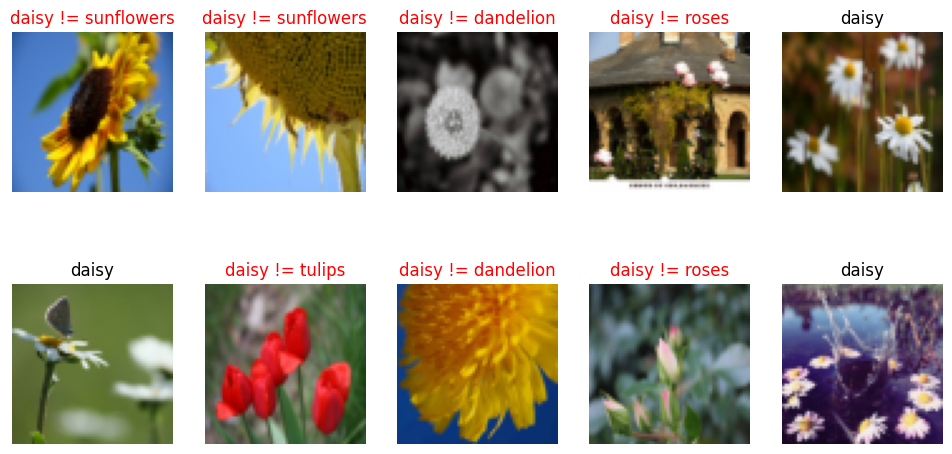

In [102]:
model_tree_pca, scores_tree_pca = arbol_vgg16_pca(X_train_rgb_64, y_train_encoded, X_test_rgb_64, y_test_encoded, input_shape=(64,64,3))

In [109]:
print(scores_tree_pca)

{'fit_time': array([2.0969615 , 2.09246373, 2.24219704, 2.21344399, 2.15724707]), 'score_time': array([0.01099706, 0.00998712, 0.01115298, 0.01300621, 0.00999522]), 'test_accuracy': array([0.38559322, 0.41384181, 0.40112994, 0.42231638, 0.47175141]), 'test_precision': array([0.38396418, 0.40914838, 0.39453507, 0.41153651, 0.461122  ]), 'test_recall': array([0.38392835, 0.41108042, 0.39469703, 0.41286745, 0.46034558]), 'test_f1': array([0.38297892, 0.40828347, 0.39427767, 0.41137591, 0.45996553]), 'test_roc_auc': array([0.61478894, 0.63208578, 0.62228752, 0.63406091, 0.66379507])}
